Import necessary dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [4]:
data = pd.read_csv('datasets/IoT_Modbus.csv')

# TODO: Complete EDA

Combine 'date' and 'time' into a single datetime column

In [5]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

/var/folders/qx/28c_j79n3zn_3rkwzsdcmn240000gn/T/ipykernel_8527/2882021498.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])


Extract time features

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Data preprocessing (Normalization)

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = MinMaxScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229755 entries, 541 to 184368
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 11.4 MB


# Execution model
## Create model

In [10]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(adjusted_hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        out = self.fc(last_time_step_out)
        return out

Initialize model

In [11]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 1

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [13]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Construct Data Loader

In [14]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Training model

In [15]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')

    pbar.update(1)
pbar.reset()

  1%|          | 1/100 [00:26<43:33, 26.40s/it]

Epoch [1/100], Loss: 0.5861759767644816, Accuracy: 0.8739597841225627


  2%|▏         | 2/100 [00:53<43:26, 26.60s/it]

Epoch [2/100], Loss: 0.5893432547794838, Accuracy: 0.8626001044568246


  3%|▎         | 3/100 [01:19<42:37, 26.37s/it]

Epoch [3/100], Loss: 0.5670155983394148, Accuracy: 0.8790912256267409


  4%|▍         | 4/100 [01:44<41:22, 25.85s/it]

Epoch [4/100], Loss: 0.5696175868305059, Accuracy: 0.8751001044568245


  5%|▌         | 5/100 [02:10<41:18, 26.09s/it]

Epoch [5/100], Loss: 0.6648038193519928, Accuracy: 0.8599190459610028


  6%|▌         | 6/100 [02:36<40:53, 26.10s/it]

Epoch [6/100], Loss: 0.639441858694612, Accuracy: 0.8700992339832869


  7%|▋         | 7/100 [03:03<40:37, 26.21s/it]

Epoch [7/100], Loss: 0.5969637390862613, Accuracy: 0.8806972493036211


  8%|▊         | 8/100 [03:29<40:14, 26.24s/it]

Epoch [8/100], Loss: 0.5909264285952823, Accuracy: 0.8859375


  9%|▉         | 9/100 [03:56<40:13, 26.52s/it]

Epoch [9/100], Loss: 0.5313014482982313, Accuracy: 0.9031815807799443


 10%|█         | 10/100 [04:23<39:38, 26.43s/it]

Epoch [10/100], Loss: 0.49800392553861744, Accuracy: 0.9079169568245126


 11%|█         | 11/100 [04:49<39:15, 26.47s/it]

Epoch [11/100], Loss: 0.4772864595913797, Accuracy: 0.9116121169916435


 12%|█▏        | 12/100 [05:16<38:52, 26.51s/it]

Epoch [12/100], Loss: 0.46592001514821646, Accuracy: 0.9149982590529248


 13%|█▎        | 13/100 [05:42<38:15, 26.38s/it]

Epoch [13/100], Loss: 0.44822318046062204, Accuracy: 0.9202080431754874


 14%|█▍        | 14/100 [06:08<37:32, 26.19s/it]

Epoch [14/100], Loss: 0.42816455178221396, Accuracy: 0.9237595752089136


 15%|█▌        | 15/100 [06:32<36:20, 25.66s/it]

Epoch [15/100], Loss: 0.41006841269698496, Accuracy: 0.9266364902506964


 16%|█▌        | 16/100 [06:56<35:21, 25.26s/it]

Epoch [16/100], Loss: 0.39430066744249764, Accuracy: 0.9280336002785515


 17%|█▋        | 17/100 [07:21<34:41, 25.08s/it]

Epoch [17/100], Loss: 0.3853223816092977, Accuracy: 0.9292305013927576


 18%|█▊        | 18/100 [07:45<34:01, 24.90s/it]

Epoch [18/100], Loss: 0.3782224466284962, Accuracy: 0.930462221448468


 19%|█▉        | 19/100 [08:10<33:30, 24.82s/it]

Epoch [19/100], Loss: 0.37546166005530157, Accuracy: 0.9310410863509749


 20%|██        | 20/100 [08:35<33:04, 24.81s/it]

Epoch [20/100], Loss: 0.36754974775003824, Accuracy: 0.9321901114206128


 21%|██        | 21/100 [09:00<32:45, 24.88s/it]

Epoch [21/100], Loss: 0.3642050663197249, Accuracy: 0.9330779944289693


 22%|██▏       | 22/100 [09:25<32:14, 24.80s/it]

Epoch [22/100], Loss: 0.35839437704086397, Accuracy: 0.9334305362116991


 23%|██▎       | 23/100 [09:48<31:25, 24.49s/it]

Epoch [23/100], Loss: 0.3549382252350042, Accuracy: 0.9343227715877437


 24%|██▍       | 24/100 [10:12<30:43, 24.26s/it]

Epoch [24/100], Loss: 0.349861333953266, Accuracy: 0.9349059888579387


 25%|██▌       | 25/100 [10:36<30:09, 24.13s/it]

Epoch [25/100], Loss: 0.34688948013908466, Accuracy: 0.9355849582172702


 26%|██▌       | 26/100 [11:00<29:37, 24.01s/it]

Epoch [26/100], Loss: 0.34339942398584905, Accuracy: 0.9358722144846797


 27%|██▋       | 27/100 [11:23<29:06, 23.92s/it]

Epoch [27/100], Loss: 0.3412159024206315, Accuracy: 0.9362073467966574


 28%|██▊       | 28/100 [11:47<28:37, 23.85s/it]

Epoch [28/100], Loss: 0.33835130676373854, Accuracy: 0.9362204038997215


 29%|██▉       | 29/100 [12:11<28:09, 23.80s/it]

Epoch [29/100], Loss: 0.335943169955141, Accuracy: 0.9363683844011143


 30%|███       | 30/100 [12:34<27:44, 23.78s/it]

Epoch [30/100], Loss: 0.3339661277605682, Accuracy: 0.9361899373259053


 31%|███       | 31/100 [12:58<27:18, 23.75s/it]

Epoch [31/100], Loss: 0.3320172676739874, Accuracy: 0.9362421657381615


 32%|███▏      | 32/100 [13:22<27:00, 23.83s/it]

Epoch [32/100], Loss: 0.330875827476146, Accuracy: 0.9362421657381615


 33%|███▎      | 33/100 [13:46<26:34, 23.80s/it]

Epoch [33/100], Loss: 0.33098085369694413, Accuracy: 0.9356110724233984


 34%|███▍      | 34/100 [14:10<26:14, 23.85s/it]

Epoch [34/100], Loss: 0.337422575277623, Accuracy: 0.9321596448467967


 35%|███▌      | 35/100 [14:34<26:00, 24.00s/it]

Epoch [35/100], Loss: 0.3507774802998221, Accuracy: 0.928133704735376


 36%|███▌      | 36/100 [14:58<25:42, 24.11s/it]

Epoch [36/100], Loss: 0.3325087358351463, Accuracy: 0.9334871169916434


 37%|███▋      | 37/100 [15:23<25:21, 24.16s/it]

Epoch [37/100], Loss: 0.32533124272062575, Accuracy: 0.9342400766016713


 38%|███▊      | 38/100 [15:47<24:59, 24.19s/it]

Epoch [38/100], Loss: 0.35622360766670336, Accuracy: 0.9260445682451254


 39%|███▉      | 39/100 [16:11<24:37, 24.23s/it]

Epoch [39/100], Loss: 0.3549579388551584, Accuracy: 0.9271108983286908


 40%|████      | 40/100 [16:36<24:17, 24.29s/it]

Epoch [40/100], Loss: 0.3337612657438461, Accuracy: 0.9338614206128134


 41%|████      | 41/100 [17:01<24:05, 24.51s/it]

Epoch [41/100], Loss: 0.3213582125502598, Accuracy: 0.9359940807799443


 42%|████▏     | 42/100 [17:25<23:39, 24.48s/it]

Epoch [42/100], Loss: 0.3506112015354442, Accuracy: 0.9273024025069638


 43%|████▎     | 43/100 [17:49<23:03, 24.26s/it]

Epoch [43/100], Loss: 0.3848005756684633, Accuracy: 0.9180492688022284


 44%|████▍     | 44/100 [18:13<22:30, 24.11s/it]

Epoch [44/100], Loss: 0.32726780693981067, Accuracy: 0.938266016713092


 45%|████▌     | 45/100 [18:36<22:00, 24.01s/it]

Epoch [45/100], Loss: 0.31881741054736573, Accuracy: 0.9376566852367688


 46%|████▌     | 46/100 [19:00<21:32, 23.94s/it]

Epoch [46/100], Loss: 0.36585070999062486, Accuracy: 0.9223929317548747


 47%|████▋     | 47/100 [19:24<21:05, 23.88s/it]

Epoch [47/100], Loss: 0.37673122725680097, Accuracy: 0.919729282729805


 48%|████▊     | 48/100 [19:48<20:40, 23.85s/it]

Epoch [48/100], Loss: 0.33013869388730366, Accuracy: 0.9382529596100279


 49%|████▉     | 49/100 [20:12<20:15, 23.83s/it]

Epoch [49/100], Loss: 0.3258992474354642, Accuracy: 0.9368863161559888


 50%|█████     | 50/100 [20:35<19:49, 23.79s/it]

Epoch [50/100], Loss: 0.3755384440600283, Accuracy: 0.9196248259052925


 51%|█████     | 51/100 [20:59<19:25, 23.78s/it]

Epoch [51/100], Loss: 0.3762693017306577, Accuracy: 0.9188892757660168


 52%|█████▏    | 52/100 [21:23<19:10, 23.98s/it]

Epoch [52/100], Loss: 0.36261457951393294, Accuracy: 0.9233330431754875


 53%|█████▎    | 53/100 [21:48<18:53, 24.12s/it]

Epoch [53/100], Loss: 0.3681322498038165, Accuracy: 0.9214963440111421


 54%|█████▍    | 54/100 [22:12<18:34, 24.23s/it]

Epoch [54/100], Loss: 0.36154368308297163, Accuracy: 0.9266974233983287


 55%|█████▌    | 55/100 [22:37<18:12, 24.27s/it]

Epoch [55/100], Loss: 0.36417703082144903, Accuracy: 0.9231458913649025


 56%|█████▌    | 56/100 [23:01<17:51, 24.36s/it]

Epoch [56/100], Loss: 0.3941054042664387, Accuracy: 0.9135532729805014


 57%|█████▋    | 57/100 [23:26<17:28, 24.39s/it]

Epoch [57/100], Loss: 0.3595864863604326, Accuracy: 0.9313544568245126


 58%|█████▊    | 58/100 [23:50<17:06, 24.43s/it]

Epoch [58/100], Loss: 0.4007887972928971, Accuracy: 0.9126566852367688


 59%|█████▉    | 59/100 [24:15<16:39, 24.37s/it]

Epoch [59/100], Loss: 0.3634939774801278, Accuracy: 0.9297484331476323


 60%|██████    | 60/100 [24:40<16:27, 24.69s/it]

Epoch [60/100], Loss: 0.40401004791144374, Accuracy: 0.9125391713091922


 61%|██████    | 61/100 [25:04<16:00, 24.63s/it]

Epoch [61/100], Loss: 0.38018169749030534, Accuracy: 0.9269150417827298


 62%|██████▏   | 62/100 [25:29<15:31, 24.52s/it]

Epoch [62/100], Loss: 0.4189528741459107, Accuracy: 0.9090268105849583


 63%|██████▎   | 63/100 [25:53<15:08, 24.55s/it]

Epoch [63/100], Loss: 0.3712143063802575, Accuracy: 0.9243950208913649


 64%|██████▍   | 64/100 [26:19<14:53, 24.81s/it]

Epoch [64/100], Loss: 0.41697090498614403, Accuracy: 0.9090094011142061


 65%|██████▌   | 65/100 [26:43<14:27, 24.77s/it]

Epoch [65/100], Loss: 0.36839900146463056, Accuracy: 0.9283426183844011


 66%|██████▌   | 66/100 [27:08<13:58, 24.65s/it]

Epoch [66/100], Loss: 0.3996539391411034, Accuracy: 0.916591225626741


 67%|██████▋   | 67/100 [27:32<13:30, 24.55s/it]

Epoch [67/100], Loss: 0.3711859781114665, Accuracy: 0.9257486072423399


 68%|██████▊   | 68/100 [27:56<12:58, 24.33s/it]

Epoch [68/100], Loss: 0.3553058031044979, Accuracy: 0.9304970403899722


 69%|██████▉   | 69/100 [28:21<12:37, 24.43s/it]

Epoch [69/100], Loss: 0.36792035835738124, Accuracy: 0.9279117339832869


 70%|███████   | 70/100 [28:45<12:12, 24.40s/it]

Epoch [70/100], Loss: 0.37389733836415784, Accuracy: 0.924616991643454


 71%|███████   | 71/100 [29:09<11:47, 24.41s/it]

Epoch [71/100], Loss: 0.38205714101420635, Accuracy: 0.9221883704735376


 72%|███████▏  | 72/100 [29:34<11:23, 24.42s/it]

Epoch [72/100], Loss: 0.410864009621961, Accuracy: 0.913087569637883


 73%|███████▎  | 73/100 [29:58<10:58, 24.40s/it]

Epoch [73/100], Loss: 0.41628850534109857, Accuracy: 0.9112421657381615


 74%|███████▍  | 74/100 [30:23<10:35, 24.43s/it]

Epoch [74/100], Loss: 0.43923815321015447, Accuracy: 0.9041129874651811


 75%|███████▌  | 75/100 [30:47<10:12, 24.51s/it]

Epoch [75/100], Loss: 0.4286242389826836, Accuracy: 0.9050530988857939


 76%|███████▌  | 76/100 [31:12<09:45, 24.40s/it]

Epoch [76/100], Loss: 0.46518770947301424, Accuracy: 0.8966922005571031


 77%|███████▋  | 77/100 [31:36<09:19, 24.34s/it]

Epoch [77/100], Loss: 0.41796034052779923, Accuracy: 0.9112334610027855


 78%|███████▊  | 78/100 [32:00<08:55, 24.34s/it]

Epoch [78/100], Loss: 0.4854569991812822, Accuracy: 0.886716573816156


 79%|███████▉  | 79/100 [32:24<08:31, 24.35s/it]

Epoch [79/100], Loss: 0.44274094340182757, Accuracy: 0.9042870821727019


 80%|████████  | 80/100 [32:49<08:09, 24.48s/it]

Epoch [80/100], Loss: 0.37848455003112946, Accuracy: 0.9219707520891365


 81%|████████  | 81/100 [33:14<07:47, 24.63s/it]

Epoch [81/100], Loss: 0.36031366690576666, Accuracy: 0.9284949512534819


 82%|████████▏ | 82/100 [33:38<07:20, 24.45s/it]

Epoch [82/100], Loss: 0.3577626752189872, Accuracy: 0.929099930362117


 83%|████████▎ | 83/100 [34:02<06:52, 24.28s/it]

Epoch [83/100], Loss: 0.3802483521643382, Accuracy: 0.915446552924791


 84%|████████▍ | 84/100 [34:26<06:26, 24.15s/it]

Epoch [84/100], Loss: 0.33576814306073766, Accuracy: 0.9301140320334261


 85%|████████▌ | 85/100 [34:50<06:00, 24.05s/it]

Epoch [85/100], Loss: 0.3478511089583, Accuracy: 0.9203386142061282


 86%|████████▌ | 86/100 [35:14<05:38, 24.19s/it]

Epoch [86/100], Loss: 0.38148992333105547, Accuracy: 0.9044176532033427


 87%|████████▋ | 87/100 [35:39<05:16, 24.34s/it]

Epoch [87/100], Loss: 0.2967645268857034, Accuracy: 0.9375261142061281


 88%|████████▊ | 88/100 [36:04<04:52, 24.42s/it]

Epoch [88/100], Loss: 0.5055969066147744, Accuracy: 0.9543262534818941


 89%|████████▉ | 89/100 [36:27<04:26, 24.26s/it]

Epoch [89/100], Loss: 0.29658842844782596, Accuracy: 0.9531728760445682


 90%|█████████ | 90/100 [36:51<04:01, 24.14s/it]

Epoch [90/100], Loss: 0.2753080170994201, Accuracy: 0.9550313370473538


 91%|█████████ | 91/100 [37:16<03:39, 24.34s/it]

Epoch [91/100], Loss: 0.30700283487248464, Accuracy: 0.9546352715877438


 92%|█████████▏| 92/100 [37:41<03:15, 24.46s/it]

Epoch [92/100], Loss: 0.3097225893277891, Accuracy: 0.9466878481894151


 93%|█████████▎| 93/100 [38:05<02:51, 24.43s/it]

Epoch [93/100], Loss: 0.29914238384826175, Accuracy: 0.9445595403899721


 94%|█████████▍| 94/100 [38:30<02:26, 24.42s/it]

Epoch [94/100], Loss: 0.2984274129432249, Accuracy: 0.944133008356546


 95%|█████████▌| 95/100 [38:54<02:01, 24.32s/it]

Epoch [95/100], Loss: 0.29050543551350494, Accuracy: 0.9446117688022284


 96%|█████████▌| 96/100 [39:18<01:37, 24.25s/it]

Epoch [96/100], Loss: 0.28858505154270586, Accuracy: 0.944537778551532


 97%|█████████▋| 97/100 [39:42<01:12, 24.27s/it]

Epoch [97/100], Loss: 0.2854938298748122, Accuracy: 0.9450861768802229


 98%|█████████▊| 98/100 [40:06<00:48, 24.23s/it]

Epoch [98/100], Loss: 0.2804442816829659, Accuracy: 0.9460132311977716


 99%|█████████▉| 99/100 [40:30<00:24, 24.20s/it]

Epoch [99/100], Loss: 0.27539497928640216, Accuracy: 0.9470926183844011


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.27898269417229477, Accuracy: 0.947836873259053


Visualizing the training process

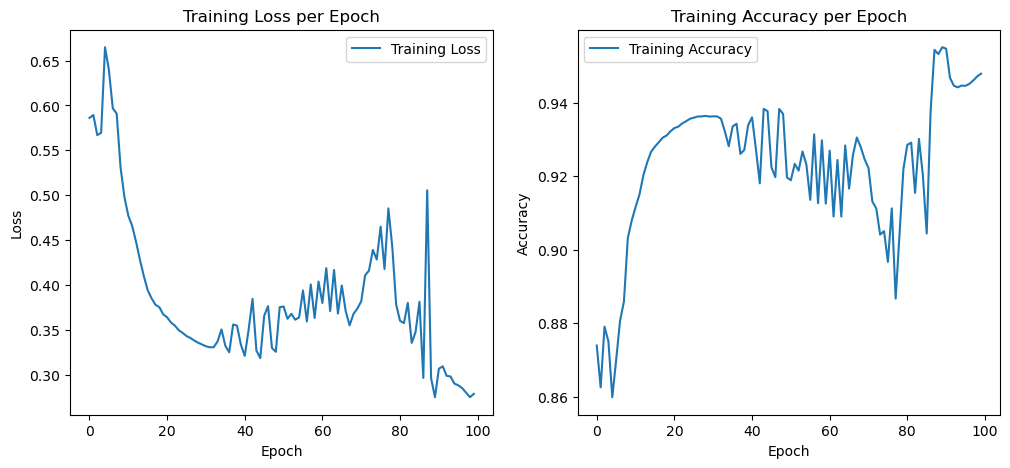

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [17]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.8779226657845715 , Precision:  0.5327701718613458 , Recall:  0.9246713852376137 , F1:  0.6760303086305673


Save model

In [18]:
save_folder = "save_model"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_lstm_{current_time}.pt"
if multiplier == 1:
    model_filename = f"model_lstm_{current_time}_without_width_multiplier.pt"
full_path = os.path.join(save_folder, model_filename)
torch.save(model.state_dict(), full_path)

print("Model saved as:", full_path)

Model saved as: save_model/model_lstm_2023-11-22_07-38-50_without_width_multiplier.pt
